<a href="https://colab.research.google.com/github/insoucyant/MachineLearning/blob/main/PricePredictiounUsingPyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d camnugent/california-housing-prices
!unzip california-housing-prices.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists
Dataset URL: https://www.kaggle.com/datasets/camnugent/california-housing-prices
License(s): CC0-1.0
Archive:  california-housing-prices.zip
  inflating: housing.csv             


In [5]:
# https://www.kaggle.com/code/realshivarv/simple-housing-price-predictor-using-pytorch
# https://www.kaggle.com/code/xixihaha318/house-prices-predict-with-pytorch
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.base import BaseEstimator
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
# import helper_functions as hp
import seaborn as sns
import pandas as pd
import numpy as np
import joblib,itertools,matplotlib

In [6]:
housing_data = pd.read_csv('housing.csv')
housing_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [7]:
print(housing_data.shape)
print(housing_data.info())
for i in housing_data.columns:
  print(f'Column name is: {i} and it has {len(housing_data[i].unique()) }unique values')

(20640, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB
None
Column name is: longitude and it has 844unique values
Column name is: latitude and it has 862unique values
Column name is: housing_median_age and it has 52unique values
Column name is: total_rooms and it has 5926unique values
Column n

In [8]:
numeric_feature_index = housing_data.dtypes[housing_data.dtypes != 'object'].index
categorical_feature_index = housing_data.dtypes[housing_data.dtypes == 'object'].index
label_feature_index = numeric_feature_index[-1]
numeric_feature_index = numeric_feature_index[:-1]
housing_data[numeric_feature_index]= housing_data[numeric_feature_index].apply(
    lambda x: (x - x.mean())/(x.std())
)
housing_data[numeric_feature_index]= housing_data[numeric_feature_index].fillna(0)

if np.all(housing_data[numeric_feature_index].isnull()):
  print("There are nulls still")
housing_data

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-1.327803,1.052523,0.982119,-0.804800,-0.970301,-0.974405,-0.977009,2.344709,452600.0,NEAR BAY
1,-1.322812,1.043159,-0.607004,2.045841,1.348243,0.861418,1.669921,2.332181,358500.0,NEAR BAY
2,-1.332794,1.038478,1.856137,-0.535733,-0.825541,-0.820757,-0.843616,1.782656,352100.0,NEAR BAY
3,-1.337785,1.038478,1.856137,-0.624199,-0.718750,-0.766010,-0.733764,0.932945,341300.0,NEAR BAY
4,-1.337785,1.038478,1.856137,-0.462393,-0.611959,-0.759828,-0.629142,-0.012881,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-0.758808,1.801603,-0.289180,-0.444974,-0.388886,-0.512579,-0.443438,-1.216099,78100.0,INLAND
20636,-0.818702,1.806285,-0.845373,-0.888682,-0.920466,-0.944382,-1.008396,-0.691576,77100.0,INLAND
20637,-0.823693,1.778194,-0.924829,-0.174991,-0.125468,-0.369528,-0.174037,-1.142566,92300.0,INLAND
20638,-0.873605,1.778194,-0.845373,-0.355591,-0.305826,-0.604415,-0.393743,-1.054557,84700.0,INLAND


In [9]:
## Object
data_dummies = pd.get_dummies(housing_data, dummy_na=True)
data_dummies

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN,ocean_proximity_nan
0,-1.327803,1.052523,0.982119,-0.804800,-0.970301,-0.974405,-0.977009,2.344709,452600.0,False,False,False,True,False,False
1,-1.322812,1.043159,-0.607004,2.045841,1.348243,0.861418,1.669921,2.332181,358500.0,False,False,False,True,False,False
2,-1.332794,1.038478,1.856137,-0.535733,-0.825541,-0.820757,-0.843616,1.782656,352100.0,False,False,False,True,False,False
3,-1.337785,1.038478,1.856137,-0.624199,-0.718750,-0.766010,-0.733764,0.932945,341300.0,False,False,False,True,False,False
4,-1.337785,1.038478,1.856137,-0.462393,-0.611959,-0.759828,-0.629142,-0.012881,342200.0,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,-0.758808,1.801603,-0.289180,-0.444974,-0.388886,-0.512579,-0.443438,-1.216099,78100.0,False,True,False,False,False,False
20636,-0.818702,1.806285,-0.845373,-0.888682,-0.920466,-0.944382,-1.008396,-0.691576,77100.0,False,True,False,False,False,False
20637,-0.823693,1.778194,-0.924829,-0.174991,-0.125468,-0.369528,-0.174037,-1.142566,92300.0,False,True,False,False,False,False
20638,-0.873605,1.778194,-0.845373,-0.355591,-0.305826,-0.604415,-0.393743,-1.054557,84700.0,False,True,False,False,False,False


Categorical Variables

In [10]:
pd.get_dummies(housing_data['ocean_proximity']).head()
# housing_data_OHE = pd.concat([housing_data, pd.get_dummies(housing_data['ocean_proximity'])], axis=1)
# housing_data_OHE.drop('ocean_proximity', axis=1, inplace=True)
# housing_data_OHE

,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,False,False,False,True,False
1,False,False,False,True,False
2,False,False,False,True,False
3,False,False,False,True,False
4,False,False,False,True,False


In [11]:
cont_features =['housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income']
cat_features = ['ocean_proximity']
y_feature = ['median_house_value']
X = housing_data[cont_features + cat_features]
y = housing_data[y_feature]

# Price Normalizer
price_normalizer = StandardScaler().fit(y.to_numpy().reshape(-1,1))
y_norm = price_normalizer.transform(y.to_numpy().reshape(-1,1))
X_train, X_eval, y_train, y_eval = train_test_split(X, y_norm, test_size=0.2, random_state=0)

In [18]:
y.shape

(20640, 1)

#### Model Pipeline Builder

In [14]:
def model_pipeline_builder(model: BaseEstimator) -> Pipeline:
  model_pipeline = Pipeline([
      ('transformer', ColumnTransformer ([
          ('onehot', OneHotEncoder(), cat_features),
          ('normalizer', StandardScaler(), cont_features)
      ], remainder='passthrough')),
      ('model', model)
      ])

In [15]:
# Set Hyperparmeters
EPOCHS, BATCH_SIZE, LEARNING_RATE, L1_LAMBDA = 1000, 16, 0.01, 0.01
torch.random.manual_seed(0)

In [16]:
# Build data preprocessing pipeline
pytorch_model_preprocessing_pipeline = Pipeline([
    ('transformer', ColumnTransformer ([
        ('onehot', OneHotEncoder(), cat_features),
        ('normalizer', StandardScaler(), cont_features)
    ], remainder='passthrough'))
])

In [17]:
# Preprocess both training and evaluation data
X_train_torch = pytorch_model_preprocessing_pipeline.fit_transform(X_train)
X_eval_torch = pytorch_model_preprocessing_pipeline.transform(X_eval)

# Pack all the data and price arrays to pytorch tensorsets
train_tensorset = TensorDataset(
    torch.tensor(X_train_torch, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.float32)
)

eval_tensorset = TensorDataset(
    torch.tensor(X_eval_torch, dtype=torch.float32),
    torch.tensor(y_eval, dtype=torch.float32)
)



# Compile the tensorsets into Pythorch DataLoaders
train_tensordataset = DataLoader(train_tensorset, batch_size=BATCH_SIZE, shuffle=True)
eval_tensordataset = DataLoader(eval_tensorset, batch_size=BATCH_SIZE, shuffle=False)

In [19]:
print(train_tensorset[10])
train_tensorset

(tensor([ 1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.4270, -0.4514, -0.5844,
        -0.3696, -0.4951,  0.3796]), tensor([-0.0299]))


In [14]:
eval_tensorset[10]

(tensor([ 1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0619, -0.5575, -0.4940,
         -0.6705, -0.5134, -0.2848]),
 tensor([0.2690]))

# NEURAL NET MODEL

### Build FFN Neural Net

In [15]:
# Build Neural Net Model Class
class NeuralNet(nn.Module):
  def __init__(self, input_size, **kwargs):
    super().__init__(**kwargs)
    self.inputLayer = nn.Linear(input_size, 16)
    self.hiddenLayers = nn.ModuleDict({
        'hlayer1': nn.Linear(16,32),
        # 'hlayer2': nn.Linear(32,64),
        # 'hlayer3': nn.Linear(64,32),
        'hlayer4': nn.Linear(32,16),
        'hlayer5': nn.Linear(16,8)
    })
    self.outputLayer = nn.Linear(8,1)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = F.relu(self.inputLayer(x))
    for h_layer in self.hiddenLayers:
      x = F.relu(self.hiddenLayers[h_layer](x))
    x = self.outputLayer(x)

    return x

  @staticmethod
  def build_new_model(input_size: int, lr: int) -> tuple:
    model = NeuralNet(input_size=input_size)
    loss_fn = nn.L1Loss()

    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    return model, loss_fn, optimizer

### Build and Train Model

In [17]:
%%time
# Instantiate model and relevant objects
baseline_neuralnet, loss_func, optimizer = NeuralNet.build_new_model(
    input_size=X_train_torch.shape[1], lr=LEARNING_RATE
)

# Calculate the total number of weights in the model
nWeights = 0
for params in baseline_neuralnet.named_parameters():
  if 'bias' not in params[0]:
    nWeights += params[1].numel()

# Instantiate metrics to be tracked
train_losses, eval_losses = [], []

# Train the Model
for epoch in range(EPOCHS):
  print(f"Epoch {epoch+1}/{EPOCHS}")
  baseline_neuralnet.train()
  batchLosses = []

  for X_batch, y_batch in train_tensordataset:
    y_pred = baseline_neuralnet(X_batch)
    # print(y_pred, y_batch)
    loss = loss_func(y_pred, y_batch)


    # L1 regularization starts
    l1_term = 0
    for param in baseline_neuralnet.parameters():
      if 'bias' not in params[0]:
        l1_term += torch.norm(param, 1)
    l1_term = l1_term / nWeights * L1_LAMBDA
    loss -= l1_term
    # L1 regularization ends

    batchLosses.append(loss.detach().item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_losses.append(np.mean(batchLosses))
  baseline_neuralnet.eval()
  X_eval_batch, y_eval_batch = next(iter(eval_tensordataset))
  eval_pred = baseline_neuralnet(X_eval_batch)
  eval_loss = loss_func(eval_pred, y_eval_batch)
  eval_losses.append(eval_loss.detach().item())
  # print(f"Train Loss: {train_losses[-1]} | Eval Loss: {eval_losses[-1]}")




Epoch 1/1000
Epoch 2/1000
Epoch 3/1000
Epoch 4/1000
Epoch 5/1000
Epoch 6/1000
Epoch 7/1000
Epoch 8/1000
Epoch 9/1000
Epoch 10/1000
Epoch 11/1000
Epoch 12/1000
Epoch 13/1000
Epoch 14/1000
Epoch 15/1000
Epoch 16/1000
Epoch 17/1000
Epoch 18/1000
Epoch 19/1000
Epoch 20/1000
Epoch 21/1000
Epoch 22/1000
Epoch 23/1000
Epoch 24/1000
Epoch 25/1000
Epoch 26/1000
Epoch 27/1000
Epoch 28/1000
Epoch 29/1000
Epoch 30/1000
Epoch 31/1000
Epoch 32/1000
Epoch 33/1000
Epoch 34/1000
Epoch 35/1000
Epoch 36/1000
Epoch 37/1000
Epoch 38/1000
Epoch 39/1000
Epoch 40/1000
Epoch 41/1000
Epoch 42/1000
Epoch 43/1000
Epoch 44/1000
Epoch 45/1000
Epoch 46/1000
Epoch 47/1000
Epoch 48/1000
Epoch 49/1000
Epoch 50/1000
Epoch 51/1000
Epoch 52/1000
Epoch 53/1000
Epoch 54/1000
Epoch 55/1000
Epoch 56/1000
Epoch 57/1000
Epoch 58/1000
Epoch 59/1000
Epoch 60/1000
Epoch 61/1000
Epoch 62/1000
Epoch 63/1000
Epoch 64/1000
Epoch 65/1000
Epoch 66/1000
Epoch 67/1000
Epoch 68/1000
Epoch 69/1000
Epoch 70/1000
Epoch 71/1000
Epoch 72/1000
E

### Predict on Evaluation Set and Visualize losses

Pytorch FNN Model R2 Score: 0.7112451259077115 



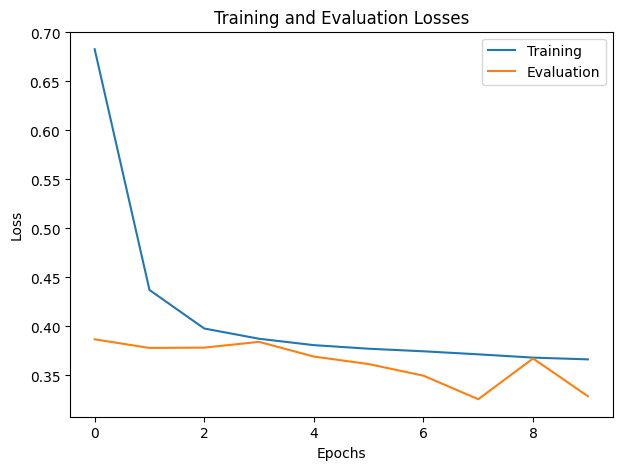

In [ ]:
import numpy.ma as ma

# Make prediction on Evaluation set using the trained model
y_pred_torch = baseline_neuralnet(torch.tensor(X_eval_torch, dtype=torch.float32)).detach().numpy()

# Impute NaN values in y_eval and y_pred_torch with their respective means
y_eval = np.where(np.isnan(y_eval), ma.array(y_eval, mask=np.isnan(y_eval)).mean(axis=0), y_eval)
y_pred_torch = np.where(np.isnan(y_pred_torch), ma.array(y_pred_torch, mask=np.isnan(y_pred_torch)).mean(axis=0), y_pred_torch)

# Calculate the R2 Score
r2_torch = r2_score(y_eval, y_pred_torch)
print(f'Pytorch FNN Model R2 Score: {r2_torch} \n')

#Visualize Losses
fig, ax= plt.subplots(1,1,figsize=(7,5))

ax.plot(train_losses, label='Training')
ax.plot(eval_losses, label='Evaluation')
ax.set_title('Training and Evaluation Losses')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()

plt.show()

# Linear

In [ ]:
# Create and train model pipeline
linear_pipeline = model_pipeline_builder(LinearRegression())
linear_pipeline.fit(X_train, y_train)
y_pred_linear = linear_pipeline.predict(X_eval)
r2_linear = r2_score(y_eval, y_pred_linear)
print(f'Linear Model R^2 Score: {r2_linear}')

# Support Vector

# DIFFERENT NN FLOW